In [26]:
import numpy as np
import matplotlib.pyplot as plt
from queue import PriorityQueue
import random
from collections import deque


# Node class for A* pathfinding
class Node:
    def __init__(self, parent=None, position=None):
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    def __eq__(self, other):
        return self.position == other.position
    def __lt__(self, other):
        return self.f < other.f
    def __hash__(self):
        return hash(self.position)
    
# Function to create a maze
def create_maze(width, height):
    shape = ((height // 2) * 2 + 1, (width // 2) * 2 + 1)
    complexity = int(0.75 * (5 * (shape[0] + shape[1])))
    density = int(0.75 * ((shape[0] // 2) * (shape[1] // 2)))

    maze = np.ones(shape, dtype=np.bool_)
    maze[1:-1, 1:-1] = False

    for i in range(density):
        x, y = np.random.randint(0, shape[1] // 2) * 2, np.random.randint(0, shape[0] // 2) * 2
        maze[y, x] = 1
        for j in range(complexity):
            neighbours = []
            if x > 1: neighbours.append((y, x - 2))
            if x < shape[1] - 2: neighbours.append((y, x + 2))
            if y > 1: neighbours.append((y - 2, x))
            if y < shape[0] - 2: neighbours.append((y + 2, x))
            if len(neighbours):
                y_, x_ = neighbours[np.random.randint(0, len(neighbours))]
                if maze[y_, x_] == 0:
                    maze[y_, x_] = 1
                    maze[y_ + (y - y_) // 2, x_ + (x - x_) // 2] = 1
                    x, y = x_, y_

    return maze

def display_maze_with_path_or_no_path(maze, path, start, end): # For showing only one algorithm
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap='Greys', interpolation='nearest')
    plt.xticks([]), plt.yticks([])
    # Display the start and end points
    plt.scatter(start[1], start[0], c='blue', marker='o', s=100)  # Start point
    plt.scatter(end[1], end[0], c='green', marker='s', s=100)  # End point
    if path:
        for position in path:
            plt.scatter(position[1], position[0], c='red', s=10)
    else:
        plt.scatter(end[1], end[0], c='red', marker='X', s=100)  # No path found
    plt.show()

    
def display_maze_with_paths(maze, paths, colors, styles, start, end, algorithms):
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap='Greys', interpolation='nearest')
    plt.xticks([]), plt.yticks([])

    # Plot the paths with different colors and styles
    for path, color, style, algorithm in zip(paths, colors, styles, algorithms):
        if path:  # If a path is found
            y, x = zip(*path)  # Separate the coordinates for plotting
            plt.plot(x, y, color=color, linestyle=style, linewidth=2, label=f'{algorithm} Path')
        else:  # If no path is found
            plt.scatter(end[1], end[0], c='red', marker='X', s=100, label=f'{algorithm} No Path')

    # Plot start and end points
    plt.scatter(start[1], start[0], c='blue', marker='o', s=100, label='Start Point')  # Start point
    plt.scatter(end[1], end[0], c='green', marker='s', s=100, label='End Point')      # End point

    # Add a legend
    plt.legend(loc='upper right')

    plt.show()


    
def get_random_end_point(maze):
    height, width = maze.shape
    while True:
        x = random.randint(1, width - 2)
        y = random.randint(1, height - 2)
        if maze[y, x] == 0:  # Check if it's not a wall (maze[y, x] should be 0)
            return (y, x)
        
# A* pathfinding function
def astar(maze, start, end):
    start_node = Node(None, tuple(start))
    end_node = Node(None, tuple(end))
    open_list = PriorityQueue()
    open_list.put((start_node.f, start_node))
    closed_set = set()

    while not open_list.empty():
        current_node = open_list.get()[1]
        closed_set.add(current_node)

        if current_node == end_node:
            path = []
            while current_node is not None:
                path.append(current_node.position)
                current_node = current_node.parent
            return path[::-1]  # Return reversed path

        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:  # Adjacent squares
            node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            if node_position[0] > (len(maze) - 1) or node_position[0] < 0 or node_position[1] > (len(maze[len(maze) - 1]) - 1) or node_position[1] < 0:
                continue

            if maze[node_position[0]][node_position[1]] != 0:
                continue

            new_node = Node(current_node, node_position)
            children.append(new_node)

        for child in children:
            if child in closed_set:
                continue

            child.g = current_node.g + 1
            child.h = ((child.position[0] - end_node.position[0]) ** 2) + ((child.position[1] - end_node.position[1]) ** 2)
            child.f = child.g + child.h

            if len([i for i in open_list.queue if child == i[1] and child.g > i[1].g]) > 0:
                continue

            open_list.put((child.f, child))

    return None

def reconstruct_path(came_from, start, end):
    current = end
    path = []
    while current != start:
        path.append(current)
        current = came_from[current]
    path.append(start)  # Optional: include start point
    return path[::-1]  # Return reversed path


def bfs(maze, start, end):
    queue = deque([start])
    visited = set()
    path = {}
    
    while queue:
        current = queue.popleft()
        if current == end:
            break
        for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            r, c = current[0] + direction[0], current[1] + direction[1]
            if 0 <= r < len(maze) and 0 <= c < len(maze[0]) and maze[r][c] == 0 and (r, c) not in visited:
                queue.append((r, c))
                visited.add((r, c))
                path[(r, c)] = current
    return reconstruct_path(path, start, end)

def dfs(maze, start, end):
    stack = [start]
    visited = set()
    path = {}
    
    while stack:
        current = stack.pop()
        if current == end:
            break
        for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            r, c = current[0] + direction[0], current[1] + direction[1]
            if 0 <= r < len(maze) and 0 <= c < len(maze[0]) and maze[r][c] == 0 and (r, c) not in visited:
                stack.append((r, c))
                visited.add((r, c))
                path[(r, c)] = current
    return reconstruct_path(path, start, end)

def heuristic(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

def greedy_best_first_search(maze, start, end):
    open_set = PriorityQueue()
    open_set.put((0, start))
    path = {}

    while not open_set.empty():
        current = open_set.get()[1]
        if current == end:
            break
        for direction in [(0, 1), (1, 0), (0, -1), (-1, 0)]:
            r, c = current[0] + direction[0], current[1] + direction[1]
            if 0 <= r < len(maze) and 0 <= c < len(maze[0]) and maze[r][c] == 0 and (r, c) not in path:
                priority = heuristic(end, (r, c))
                open_set.put((priority, (r, c)))
                path[(r, c)] = current
    return reconstruct_path(path, start, end)


# Defining the maze

In [27]:
# Define the maze size
width, height = 100, 100
# Generate maze
maze = create_maze(width, height)

# Define start and end points for the A* algorithm
start = (40,58)  # Start at the top-left corner
end = get_random_end_point(maze)  # End at the bottom-right corne

path_a_star = astar(maze, start, end)
path_bfs = bfs(maze, start, end)
path_dfs = dfs(maze, start, end)
path_greedy = greedy_best_first_search(maze, start, end)

# Compare Algorithms (A*, Greedy, BFS, DFS)

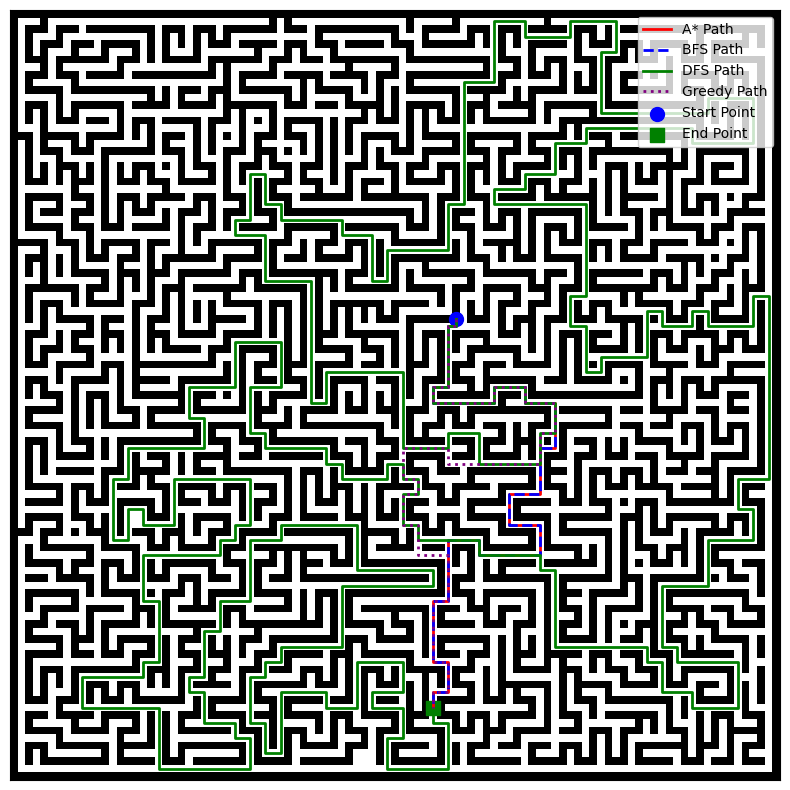

In [28]:
paths = [path_a_star, path_bfs, path_dfs, path_greedy]
# Different color for each path
colors = ['red', 'blue', 'green', 'purple']  # A*, BFS, DFS, Greedy

# Different line styles for each path
styles = ['-', '--', '-', ':']

# List of algorithm names for the legend
algorithms = ['A*', 'BFS', 'DFS', 'Greedy']

# Display the paths with the modified visualization function
display_maze_with_paths(maze, paths, colors, styles, start, end, algorithms)

# A*

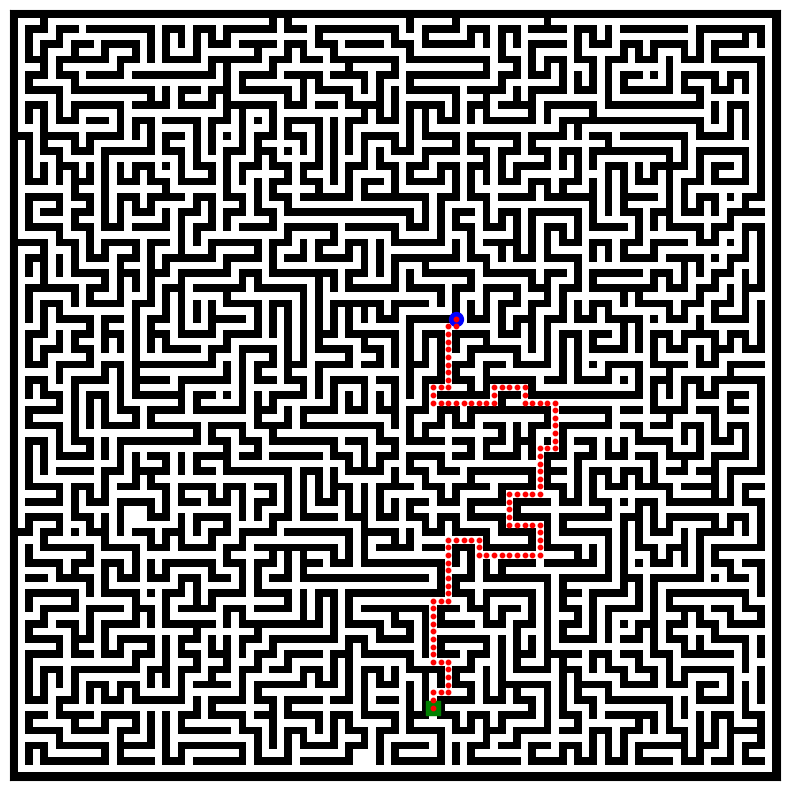

In [29]:
display_maze_with_path_or_no_path(maze, path_a_star, start, end)

# BFS

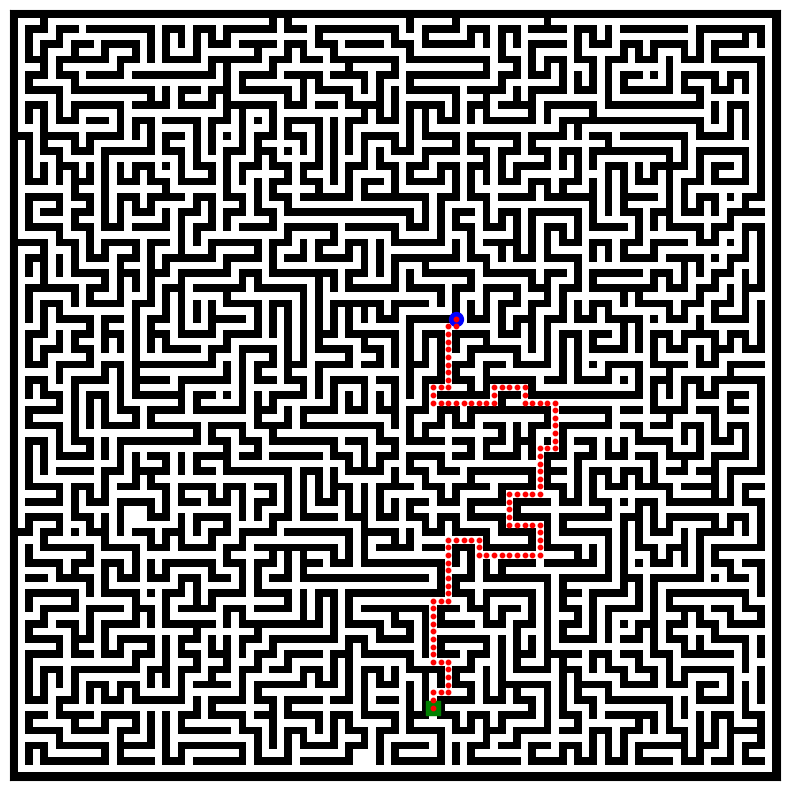

In [30]:
display_maze_with_path_or_no_path(maze, path_bfs, start, end)

# DFS

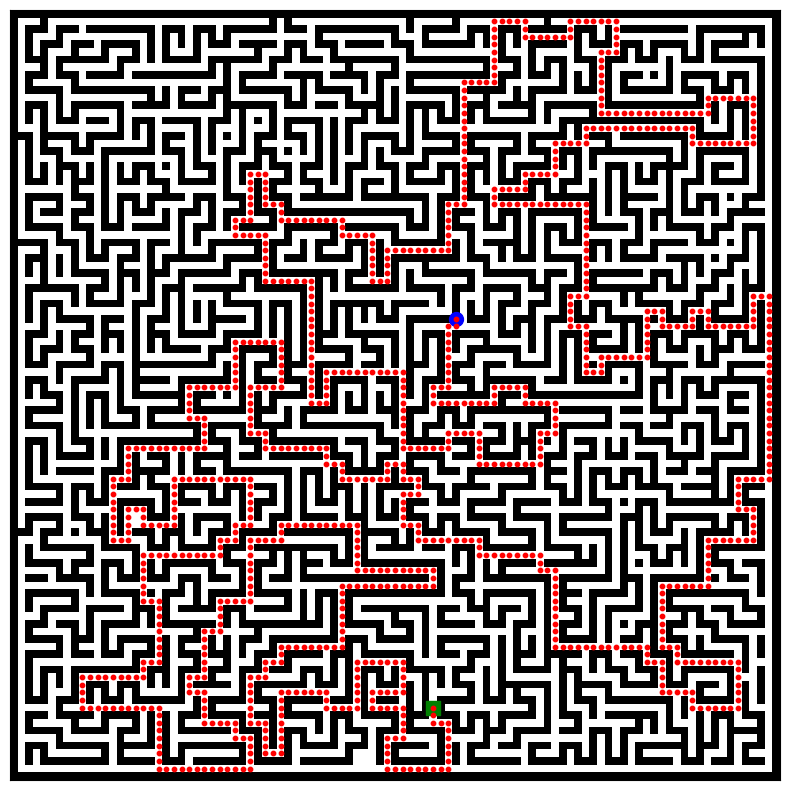

In [31]:
display_maze_with_path_or_no_path(maze, path_dfs, start, end)

# GREEDY

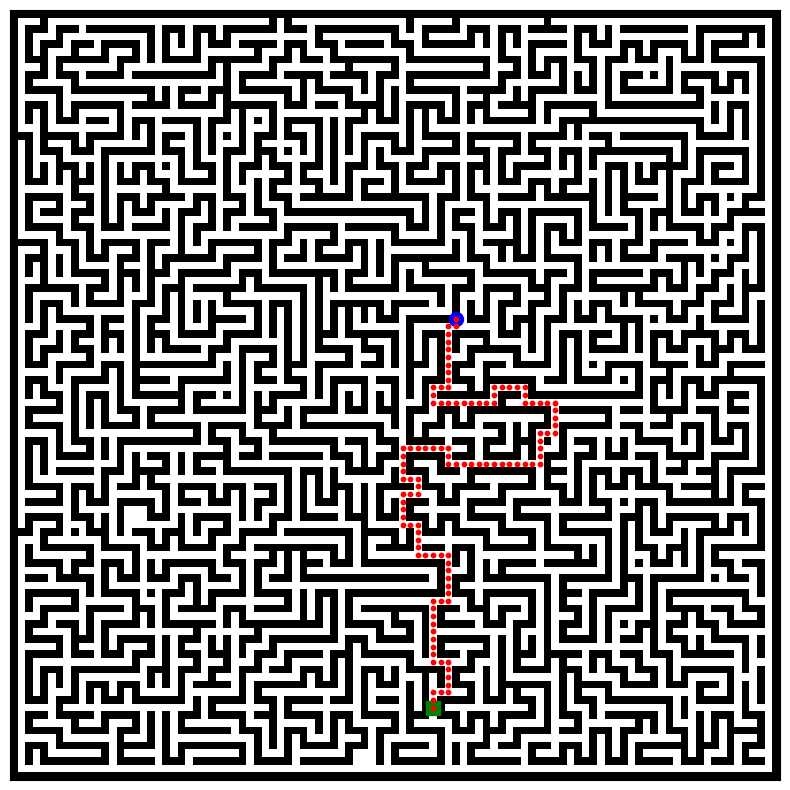

In [32]:
display_maze_with_path_or_no_path(maze, path_greedy, start, end)